# Tuning a Semantic Segmentation Transformers

We have now learned the power of the transformer architecture.
One of its applications is to perform semantic segmentation---
a computer vision task for associating each pixel in an image into a class or object.

Althgouh training a full transformer from scratch can be expensive, it is relatively easy to "tune" a pre-trained transformer to different types of data.
In this hands-on, we will use an [`implementation`](https://github.com/huggingface/transformers) of [SegFormer](https://arxiv.org/pdf/2105.15203.pdf) by [hugging face](https://huggingface.co/).

In [1]:
! pip install ipywidgets              # fix progress bars
! pip install astropy                 # to load fits files
! pip install torch datasets evaluate # deep learning ecosystem
! pip install transformers            # hugging face transformers

## Pre-trained Model

To run this hands-on with reasonable resources, we will use the [`MiT-b0`](https://huggingface.co/nvidia/mit-b0) variant of the SegFormer, 
which has only [3.7M parameters](https://huggingface.co/docs/transformers/en/model_doc/segformer).
Following the documentation, we can use it by the following steps.

**Step 1a.** Load the necessary python packages.

In [2]:
import requests       # for download image
from PIL import Image # for reading image
from transformers import SegformerImageProcessor, SegformerForImageClassification

**Step 1b.** Download a sample image and read it as a Pillow image.

In [3]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
img = Image.open(requests.get(url, stream=True).raw)

**Step 1c.** Download the pre-trained model and construct the image processor and classifier.

In [4]:
impro = SegformerImageProcessor.from_pretrained("nvidia/mit-b0")
model = SegformerForImageClassification.from_pretrained("nvidia/mit-b0")

/Users/ckc/.venv/dl/lib/python3.12/site-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


**Step 1d.** Process the input image and run it through the model. 

In [5]:
inputs  = impro(images=img, return_tensors="pt")
outputs = model(**inputs)

**Step 1e.** Obtain and print the predicted class---the model predicts one of the 1000 ImageNet classes

In [6]:
logits  = outputs.logits
predicted_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_idx])

Predicted class: tabby, tabby cat


**Exercise 1f.** Try to run the `MiT-b0` on a different image, maybe an astronomical image?
Does `MiT-b0` returns a good label?
If not, why?

*Hint:* what classes are in ImageNet?

## Semantic Segmentation

However, `SegFormer` was designed for semantic segmentation (as the [title of the paper](https://arxiv.org/abs/2105.15203) suggested).
Let's use `MiT-b0` as a semantic segmentation model.

**Step 2a.** Load the necessary python packages.

In [7]:
import numpy as np
from matplotlib   import pyplot as plt
from transformers import SegformerForSemanticSegmentation

**Step 2b.** Download the pre-trained model and construct the semantic segmentation model.

Note that there is a warning saying some weights were not initialized.
This is expected.
`SegFormer` consists of a hierarchical Transformer encoder and a lightweight all-Multilayer Perceptron (MLP) decode head.
The hierarchical Transformer is first pre-trained on ImageNet-1k, after which a decode head is added and fine-tuned altogether on a downstream dataset.
This hugging face repository only contains the pre-trained hierarchical Transformer, hence it can be used for fine-tuning purposes.

In [8]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0")

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Step 2c.** But as a demo, let's apply it to our image anyway.

In [9]:
outputs = model(**inputs)

**Step 2d.** The output of `SegFormer` is effectively an array containing an id for each pixel of the origin image.

In [10]:
segmap = impro.post_process_semantic_segmentation(outputs, target_sizes=[img.size[::-1]])[0].cpu().numpy()
display(segmap)

array([[837, 837, 837, ..., 444, 444, 444],
       [837, 837, 837, ..., 444, 444, 444],
       [837, 837, 837, ..., 444, 444, 444],
       ...,
       [391, 391, 391, ..., 196, 196, 196],
       [391, 391, 391, ..., 196, 196, 196],
       [391, 391, 391, ..., 196, 196, 196]])

**Step 3e.** We can overlay the segmentation map over the original image.
As we can see here, without tuning to down-stream data, `MiT-b0` can't really pull out objects from the image.

In [11]:
def getpalette(url="https://raw.githubusercontent.com/rndsrc/dl/main/ade_palette.txt"):
    s = requests.get(url).text
    a = np.fromstring(s, dtype=np.uint8, sep=' ')
    return a.reshape(-1,3)

palette = getpalette()

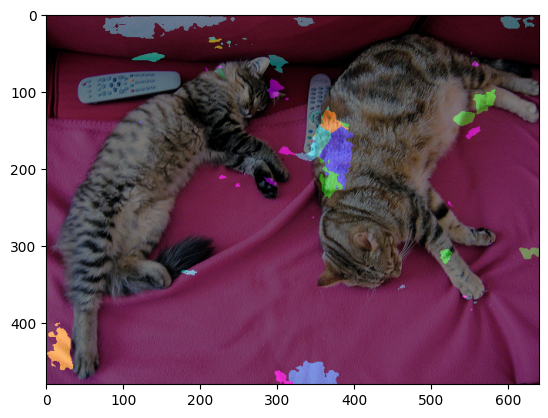

In [12]:
def segshow(img, mask, palette=palette, alpha=0.5, ax=None):
    segcolor = np.zeros(mask.shape + (3,), dtype=np.uint8)
    for l, c in enumerate(palette):
        segcolor[mask==l, :] = c
    overlay = ((1-alpha)*np.array(img) + alpha*segcolor).astype(np.uint8)

    if ax is None:
        plt.imshow(overlay)
    else:
        ax.imshow(overlay)

segshow(img, segmap)

**Exercise 2f.** Try to rerun the above cells, do you get the same segmentation?  Why?

## Tuning `SegFormer`

To make the `MiT-b0` `SegFormer` useful for astronomy, we will fine tune it for galaxy segmentation.
We will use the ["Astrophysics Division Galaxy Segmentation Benchmark Dataset"](https://registry.opendata.aws/apd_galaxysegmentation/).
For each image `imagedata_1-*.fits`, there is a corresponding mask file `mask_1-*.fits` that labels for galaxy segmentation into galactic centers, galactic bars, spiral arms and foreground stars.

**Step 3a.** Load the necessary python packages.

In [13]:
from astropy.io import fits
from torch.utils.data import Dataset

**Step 3b.** Before we tune our `SegFormer`, let's first take a look at the image and mask.

Filename: sample10/imagedata_1-118820.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     237   (208, 208)   float32   
  1                1 ImageHDU       268   (208, 208)   float32   
  2                1 ImageHDU       238   (208, 208)   float32   
  3                1 ImageHDU       253   (208, 208)   float32   
  4                1 ImageHDU       253   (208, 208)   float32   
Filename: sample10/mask_1-118820.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     236   (208, 208)   float64   


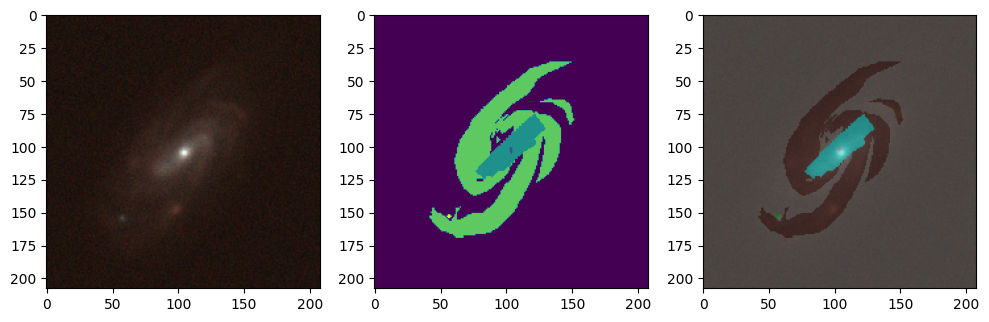

In [14]:
def normalize(a):
    a -= np.min(a)
    a *= 255 / np.max(a)
    return a.astype(np.uint8)

with fits.open("sample10/imagedata_1-118820.fits") as hdul:
    hdul.info()
    img = np.moveaxis(np.array([
        normalize(hdul[0].data),
        normalize(hdul[1].data),
        normalize(hdul[2].data),
    ]), 0, -1)

with fits.open("sample10/mask_1-118820.fits") as hdul:
    hdul.info()
    mask = np.array(hdul[0].data).astype(np.uint8)

fig, axes = plt.subplots(1,3, figsize=(12,4))
axes[0].imshow(img)
axes[1].imshow(mask)
segshow(img, mask, ax=axes[2])

In [41]:
from glob   import glob
from os     import path
from random import sample

class GalaxyDataset(Dataset):
    """Galaxy semantic segmentation dataset."""

    def __init__(self, datadir, impro, n=None):
        """
        Args:
            datadir (string): directory of the dataset containing the images + masks.
            impro (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
        """
        imgs = glob(path.join(datadir, "imagedata_*.fits"))

        self.imgs  = imgs if n is None else sample(imgs, k=n)
        self.masks = [img.replace("imagedata_", "mask_") for img in self.imgs]
        self.impro = impro

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, i):
        with fits.open(self.imgs[i]) as hdul:
            img = np.moveaxis(np.array([
                normalize(hdul[0].data),
                normalize(hdul[1].data),
                normalize(hdul[2].data),
            ]), 0, -1)

        with fits.open(self.masks[i]) as hdul:
            mask = np.array(hdul[0].data).astype(np.uint8)

        inputs = self.impro(img, mask, return_tensors="pt")
        for k in inputs:
            inputs[k].squeeze_() # remove batch dimension
        return inputs

train_dataset = GalaxyDataset("sample100", impro, n=20)
valid_dataset = GalaxyDataset("sample10",  impro)

In [42]:
encoded_inputs = train_dataset[0]
encoded_inputs["labels"].squeeze().unique()

tensor([0, 1, 2, 4])

In [31]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=5)

In [32]:
batch = next(iter(train_dataloader))

for k,v in batch.items():
    print(k, v.shape)

pixel_values torch.Size([5, 3, 512, 512])
labels torch.Size([5, 512, 512])


In [33]:
import evaluate

metric = evaluate.load("mean_iou")

In [34]:
id2label = {
    0: "background",
    1: "galactic centers", 
    2: "galactic bars",
    3: "spiral arms",
    4: "foreground stars",
}

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    num_labels=len(id2label),
    id2label=id2label,
    label2id={v:k for k,v in id2label.items()},
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(10):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)

            # note that the metric expects predictions + labels as numpy arrays
            metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
            # currently using _compute instead of compute
            # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
            metrics = metric._compute(
                predictions=predicted.cpu(),
                references=labels.cpu(),
                num_labels=len(id2label),
                ignore_index=255,
                reduce_labels=False, # we've already reduced the labels ourselves
            )

        print(f"Loss: {loss.item():.3f}; Mean iou: {metrics['mean_iou']:.3f}; Mean accuracy: {metrics['mean_accuracy']:.3f}")

Epoch: 0


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 1.623; Mean iou: 0.052; Mean accuracy: 0.283
Loss: 1.600; Mean iou: 0.052; Mean accuracy: 0.283
Loss: 1.520; Mean iou: 0.052; Mean accuracy: 0.283
Loss: 1.482; Mean iou: 0.052; Mean accuracy: 0.283
Epoch: 1


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 1.492; Mean iou: 0.195; Mean accuracy: 0.345
Loss: 1.432; Mean iou: 0.195; Mean accuracy: 0.345
Loss: 1.449; Mean iou: 0.195; Mean accuracy: 0.345
Loss: 1.400; Mean iou: 0.195; Mean accuracy: 0.345
Epoch: 2


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 1.409; Mean iou: 0.245; Mean accuracy: 0.374
Loss: 1.388; Mean iou: 0.245; Mean accuracy: 0.374
Loss: 1.306; Mean iou: 0.245; Mean accuracy: 0.374
Loss: 1.305; Mean iou: 0.245; Mean accuracy: 0.374
Epoch: 3


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 1.279; Mean iou: 0.250; Mean accuracy: 0.310
Loss: 1.300; Mean iou: 0.250; Mean accuracy: 0.310
Loss: 1.220; Mean iou: 0.250; Mean accuracy: 0.310
Loss: 1.328; Mean iou: 0.250; Mean accuracy: 0.310
Epoch: 4


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 1.266; Mean iou: 0.257; Mean accuracy: 0.407
Loss: 1.211; Mean iou: 0.257; Mean accuracy: 0.407
Loss: 1.188; Mean iou: 0.257; Mean accuracy: 0.407
Loss: 1.192; Mean iou: 0.257; Mean accuracy: 0.407
Epoch: 5


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 1.154; Mean iou: 0.328; Mean accuracy: 0.458
Loss: 1.149; Mean iou: 0.328; Mean accuracy: 0.458
Loss: 1.228; Mean iou: 0.328; Mean accuracy: 0.458
Loss: 1.147; Mean iou: 0.328; Mean accuracy: 0.458
Epoch: 6


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 1.167; Mean iou: 0.274; Mean accuracy: 0.386
Loss: 1.098; Mean iou: 0.274; Mean accuracy: 0.386
Loss: 1.137; Mean iou: 0.274; Mean accuracy: 0.386
Loss: 1.093; Mean iou: 0.274; Mean accuracy: 0.386
Epoch: 7


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 1.119; Mean iou: 0.287; Mean accuracy: 0.439
Loss: 1.076; Mean iou: 0.287; Mean accuracy: 0.439
Loss: 1.031; Mean iou: 0.287; Mean accuracy: 0.439
Loss: 1.042; Mean iou: 0.287; Mean accuracy: 0.439
Epoch: 8


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 1.023; Mean iou: 0.270; Mean accuracy: 0.332
Loss: 1.059; Mean iou: 0.270; Mean accuracy: 0.332
Loss: 1.044; Mean iou: 0.270; Mean accuracy: 0.332
Loss: 1.045; Mean iou: 0.270; Mean accuracy: 0.332
Epoch: 9


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 1.018; Mean iou: 0.327; Mean accuracy: 0.478
Loss: 0.989; Mean iou: 0.327; Mean accuracy: 0.478
Loss: 0.974; Mean iou: 0.327; Mean accuracy: 0.478
Loss: 0.933; Mean iou: 0.327; Mean accuracy: 0.478


In [36]:
inputs  = impro(images=img, return_tensors="pt")
outputs = model(**inputs)

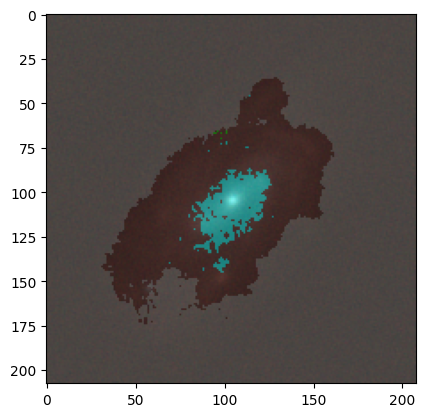

In [37]:
segmap = impro.post_process_semantic_segmentation(outputs, target_sizes=[img.shape[:-1]])[0].cpu().numpy()
segshow(img, segmap)